In [1]:
import os

try:
    import subprocess
    import sys

    from google.colab import drive

    drive.mount("/content/drive")
    subprocess.run(["pip", "install", "torchmetrics", "optuna"])
    base_dir = "/content/drive/MyDrive/Colab_Notebooks/Crack_Detection"
    sys.path.append(os.path.join(base_dir, "semantic-segmentation"))
    LOCAL = False
except ImportError:
    base_dir = "."
    LOCAL = True

import matplotlib.pyplot as plt
import torch

from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall
from torchmetrics.clustering import RandScore

from train import (
    DataLoader,
    ImageMaskTransform,
    SegmentationDataset,
    UNet,
    tune_hyperparams,
    train_fixed_hyperparams,
)


%load_ext tensorboard

In [ ]:
%tensorboard --logdir {os.path.join(base_dir, "runs")}

In [ ]:
tune_hyperparams(base_dir, LOCAL)

In [ ]:
params = {
    "batch_size": 8,
    "brightness_prob": 0.3,
    "dropout_p": 0.5329,
    "elastic_prob": 0.03,
    "flip_prob": 0.3,
    "lr": 0.000363,
    "lr_cooldown": 40,
    "lr_factor": 0.7,
    "lr_patience": 45,
    "min_lr": 1e-7,
    "rotate_prob": 0.472,
    "translate_prob": 0.3,
    "loss_w0": 1.0,
    "loss_sigma": 5.0,
    "loss_w1": 0.0,
    "use_adam": True,
    "use_cosine_scheduler": False,
    "vanilla_loss": False,
    "padding": True,
}
num_epochs = 1200
min_save_epoch = 50
early_stop_patience = 200
num_workers = 2
best_error = train_fixed_hyperparams(
    base_dir,
    LOCAL,
    params,
    num_epochs,
    min_save_epoch,
    early_stop_patience,
    num_workers,
)
print(best_error)

Epoch 1/1200, Loss/train: 0.5942, RandError/train: 0.3450, PixelError/train: 0.2216, Recall/train: 1.0000, Precision/train: 0.7784, Loss/val: 0.5414, VanillaLoss/val: 0.6407, RandError/val: 0.3356, PixelError/val: 0.2133, Recall/val: 1.0000, Precision/val: 0.7867
Epoch 2/1200, Loss/train: 0.5404, RandError/train: 0.3442, PixelError/train: 0.2209, Recall/train: 1.0000, Precision/train: 0.7791, Loss/val: 0.4596, VanillaLoss/val: 0.5170, RandError/val: 0.3356, PixelError/val: 0.2133, Recall/val: 1.0000, Precision/val: 0.7867
Epoch 3/1200, Loss/train: 0.5128, RandError/train: 0.3450, PixelError/train: 0.2217, Recall/train: 1.0000, Precision/train: 0.7783, Loss/val: 0.4247, VanillaLoss/val: 0.4750, RandError/val: 0.3356, PixelError/val: 0.2133, Recall/val: 1.0000, Precision/val: 0.7867
Epoch 4/1200, Loss/train: 0.4433, RandError/train: 0.3445, PixelError/train: 0.2212, Recall/train: 1.0000, Precision/train: 0.7788, Loss/val: 0.4020, VanillaLoss/val: 0.4540, RandError/val: 0.3356, PixelError

In [ ]:
dropout_p = 0.5329
batch_size = 1 if LOCAL else 8
padding = True
mask_size = 512 if padding else 388
input_size = 512 if padding else 572

test_image_dir = os.path.join(base_dir, "isbi_2012_challenge/test/imgs")
test_mask_dir = os.path.join(base_dir, "isbi_2012_challenge/test/labels")

test_images = os.listdir(test_image_dir)
test_transforms = ImageMaskTransform(
    train=False, mask_size=mask_size, input_size=input_size
)
test_dataset = SegmentationDataset(
    test_image_dir, test_mask_dir, test_images, transform=test_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

pretrained_weights_path = os.path.join(base_dir, "checkpoints/run_0614-200544.pth")
model = UNet(dropout_p=dropout_p, padding=padding)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
model.eval()

accuracy_metric_test = BinaryAccuracy().to(device)
precision_metric_test = BinaryPrecision().to(device)
recall_metric_test = BinaryRecall().to(device)
rand_score_metric_test = RandScore().to(device)
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        labels = labels.squeeze(1)
        preds = torch.argmax(outputs, dim=1)
        accuracy_metric_test.update(preds, labels)
        recall_metric_test.update(preds, labels)
        precision_metric_test.update(preds, labels)
        rand_score_metric_test.update(preds.view(-1), labels.view(-1))

print(
    f"Rand error: {1 - rand_score_metric_test.compute():.4f} "
    f"Pixel Error: {1 - accuracy_metric_test.compute():.4f} "
    f"Recall: {recall_metric_test.compute():.4f} "
    f"Precision: {precision_metric_test.compute():.4f}"
)

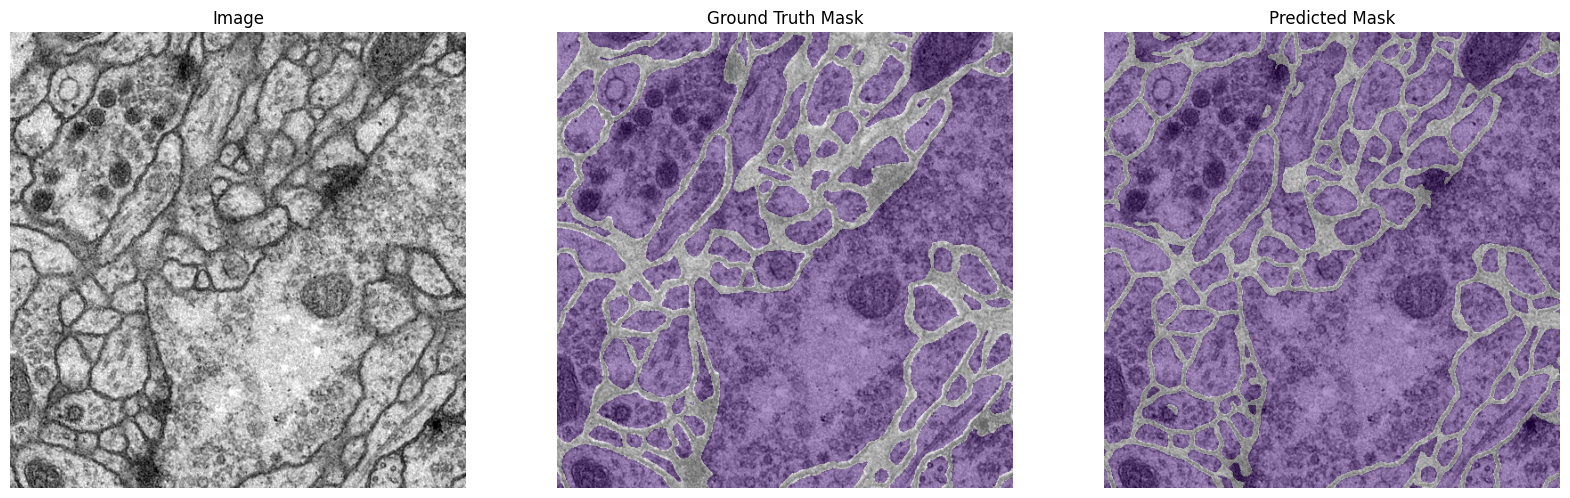

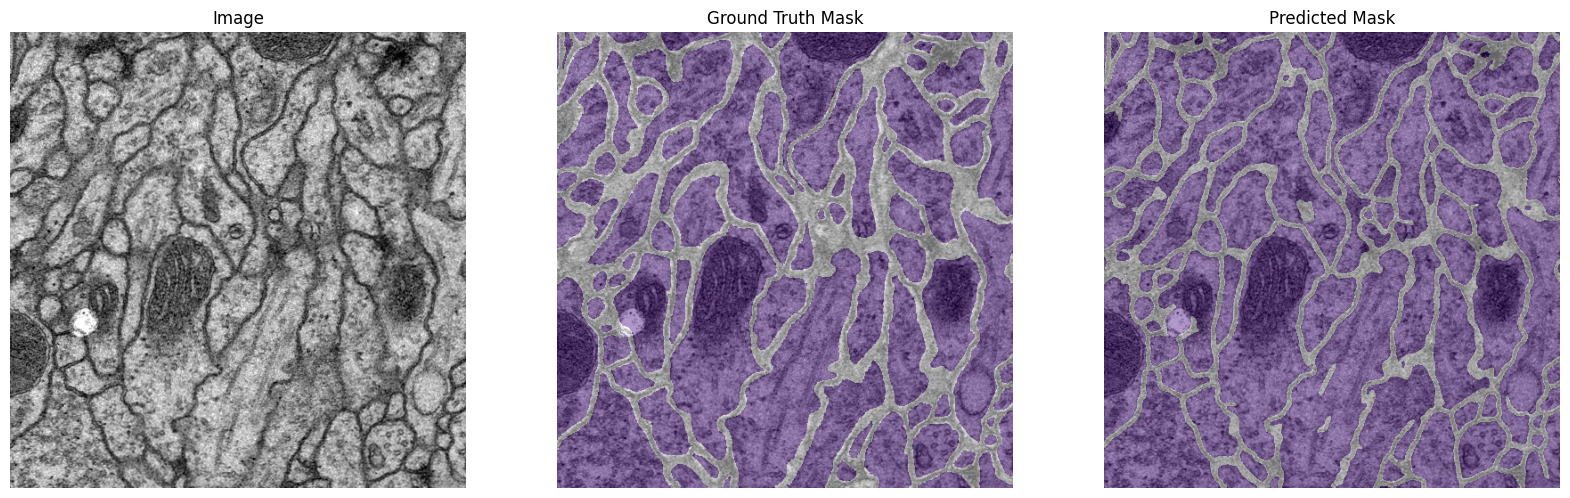

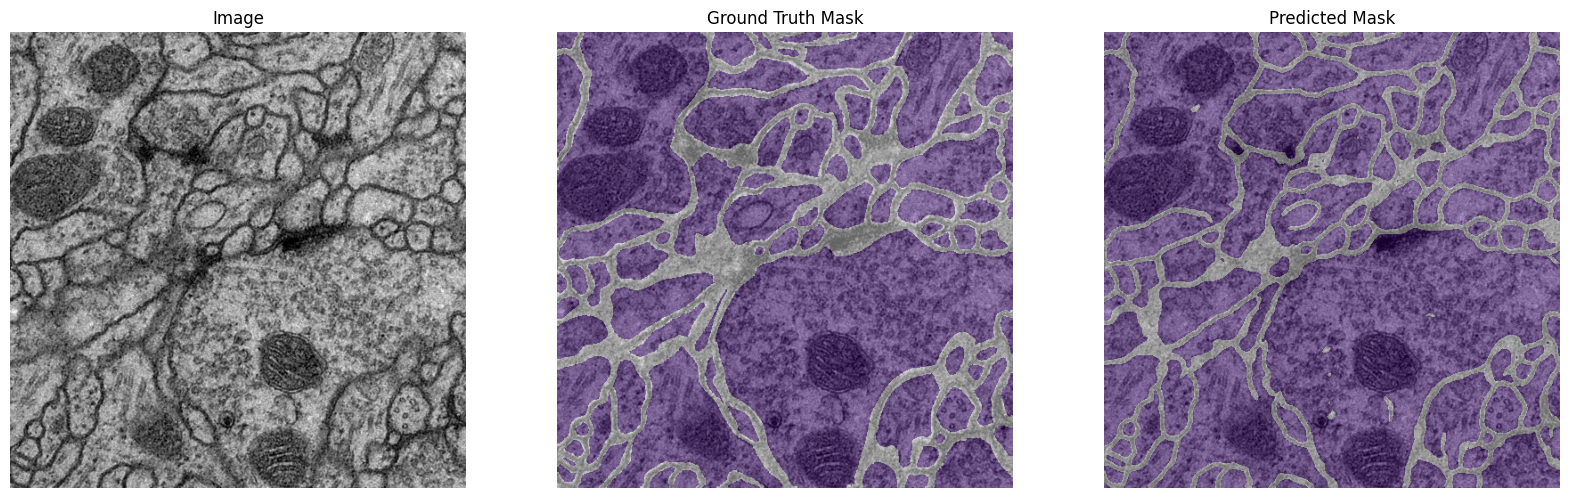

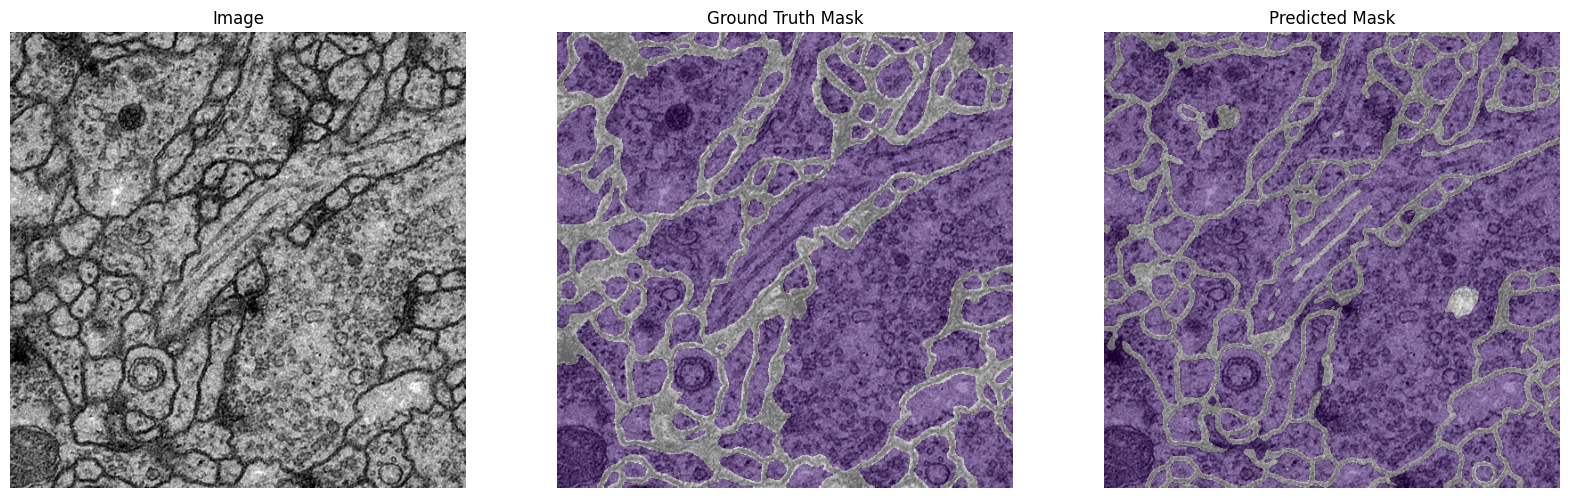

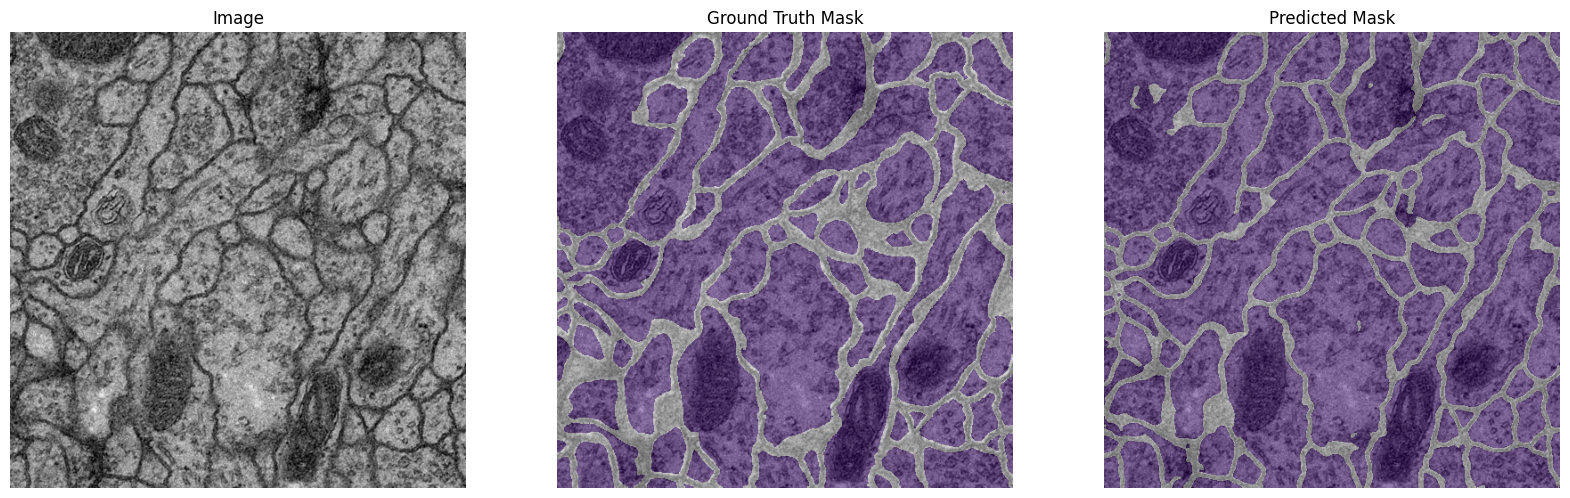

KeyboardInterrupt: 

In [6]:
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        for i in range(images.shape[0]):
            image = images[i].permute(1, 2, 0).cpu().numpy()
            mask = labels[i].cpu().numpy().squeeze()

            predicted_mask = torch.argmax(outputs[i], dim=0).cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(20, 8))
            axs[0].imshow(image, cmap="gray")
            axs[0].set_title("Image")
            axs[0].axis("off")

            axs[1].imshow(image, cmap="gray")
            axs[1].imshow(mask, cmap="Purples", alpha=0.4)
            axs[1].set_title("Ground Truth Mask")
            axs[1].axis("off")

            axs[2].imshow(image, cmap="gray")
            axs[2].imshow(predicted_mask, cmap="Purples", alpha=0.4)
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")
        plt.show()